In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

import scipy.io as scio 

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95  # sets default credible interval used by arviz
np.random.seed(0)

In [5]:
mat_file = r"E:\YuLab\Work\TimingData\TimingData.mat"
csv_file = r"E:\YuLab\Work\TimingData\TimingTable.csv"

mat_data = scio.loadmat(mat_file)
csv_data = pd.read_csv(csv_file)

# t_response_pre = mat_data["tResponse"][0][0][0].reshape(-1,)
# t_response_post = mat_data["tResponse"][0][0][1].reshape(-1,)
# t_response = np.append(t_response_pre, t_response_post)
# treatment = np.append(np.zeros_like(t_response_pre), np.ones_like(t_response_post))

t_response = np.array(csv_data["ResponseTime"])
treatment = np.array(csv_data["Treatment"])

t_response_pre = t_response[treatment==0]
t_response_post = t_response[treatment==1]

n = np.size(t_response)
# n_pre = np.size(t_response_pre)
# n_post = np.size(t_response_post)

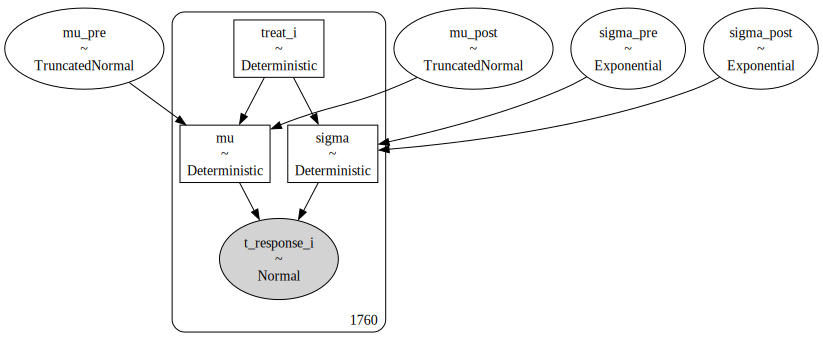

In [6]:
with pm.Model() as model_treatmeant:

    # prior of mu, wide distributed around 1.
    mu_pre  = pm.TruncatedNormal("mu_pre", mu=1., sigma=.5, lower=0.)
    mu_post = pm.TruncatedNormal("mu_post", mu=1., sigma=.5, lower=0.)

    # prior of sigma, larger than 0., and close to 0.
    sigma_pre = pm.Exponential("sigma_pre", lam=5.)
    sigma_post = pm.Exponential("sigma_post", lam=5.)

    # treatment, get from data
    treat_i = pm.Deterministic("treat_i", pt.eq(treatment, 1))

    # assign parameters to each trial, according to treatment
    mu = pm.Deterministic("mu", pt.switch(pt.eq(treat_i, 0), mu_pre, mu_post))
    sigma = pm.Deterministic("sigma", pt.switch(pt.eq(treat_i, 0), sigma_pre, sigma_post))

    # observed data
    t_response_i = pm.Normal("t_response_i", mu=mu, sigma=sigma, observed=t_response)

pm.model_to_graphviz(model_treatmeant)

In [7]:
with model_treatmeant:
    trace_treatment = pm.sample(chains=4, draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pre, mu_post, sigma_pre, sigma_post]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [8]:
az.summary(trace_treatment, var_names=["mu_pre", "mu_post", "sigma_pre", "sigma_post"])


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_pre,1.070,0.010,1.051,1.089,0.0,0.0,6753.0,2750.0,1.0
mu_post,0.853,0.014,0.826,0.878,0.0,0.0,5843.0,2886.0,1.0
sigma_pre,0.315,0.007,0.301,0.327,0.0,0.0,6344.0,3072.0,1.0
sigma_post,0.351,0.010,0.333,0.371,0.0,0.0,7838.0,3051.0,1.0


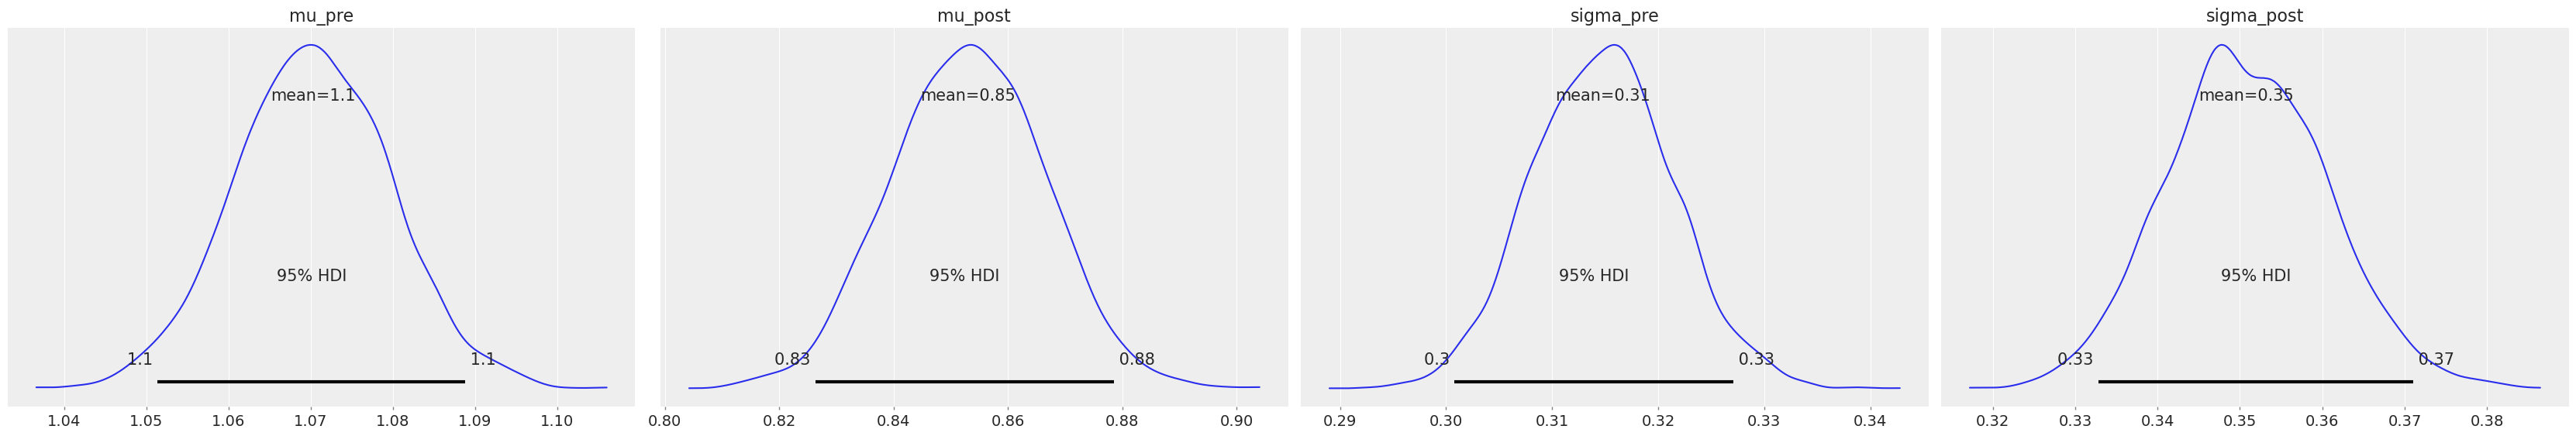

In [10]:
az.plot_posterior(trace_treatment, var_names=["mu_pre", "mu_post", "sigma_pre", "sigma_post"])
plt.show()

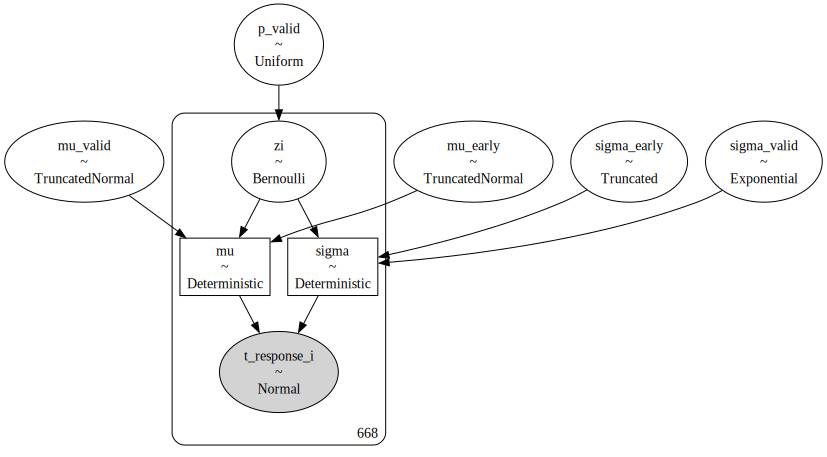

In [92]:
with pm.Model() as model_post:

    # prior of mu, wide distributed around 1.
    mu_valid = pm.TruncatedNormal("mu_valid", mu=1., sigma=.5, lower=0.)
    mu_early = pm.TruncatedNormal("mu_early", mu=0., sigma=.5, lower=0., upper=.5)

    # prior of sigma, larger than 0., and close to 0.
    # exp_dist = pm.Exponential.dist(lam=5.)
    sigma_valid = pm.Exponential("sigma_valid", lam=5.)
    sigma_early = pm.Exponential("sigma_valid", lam=5.)

    # treatment, get from data
    p_valid = pm.Uniform("p_valid", lower=.5, upper=1.)
    zi = pm.Bernoulli("zi", p=p_valid, shape=n_post)

    # assign parameters to each trial, according to treatment
    mu = pm.Deterministic("mu", pt.switch(pt.eq(zi, 1), mu_valid, mu_early))
    sigma = pm.Deterministic("sigma", pt.switch(pt.eq(zi, 1), sigma_valid, sigma_early))

    # observed data
    t_response_i = pm.Normal("t_response_i", mu=mu, sigma=sigma, observed=t_response_post)

pm.model_to_graphviz(model_post)

In [93]:
with model_post:
    trace_post = pm.sample(chains=4, draws=1000, tune=1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu_valid, mu_early, sigma_valid, sigma_early, p_valid]
>BinaryGibbsMetropolis: [zi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 188 seconds.
e:\Anaconda3\envs\pymc_env_2\lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 715 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [94]:
az.summary(trace_post, var_names=["mu_valid", "mu_early", "sigma_valid", "sigma_early", "p_valid"])


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_valid,0.880,0.014,0.858,0.915,0.003,0.002,22.0,84.0,2.12
mu_early,0.235,0.120,0.079,0.500,0.033,0.026,27.0,120.0,1.76
sigma_valid,0.453,0.011,0.441,0.480,0.004,0.003,8.0,186.0,1.58
sigma_early,0.083,0.120,0.000,0.342,0.041,0.030,6.0,161.0,1.74
p_valid,0.991,0.009,0.979,1.000,0.001,0.001,21.0,116.0,1.41


array([[<Axes: title={'center': 'mu_valid'}>,
        <Axes: title={'center': 'mu_early'}>,
        <Axes: title={'center': 'sigma_valid'}>],
       [<Axes: title={'center': 'sigma_early'}>,
        <Axes: title={'center': 'p_valid'}>, <Axes: >]], dtype=object)

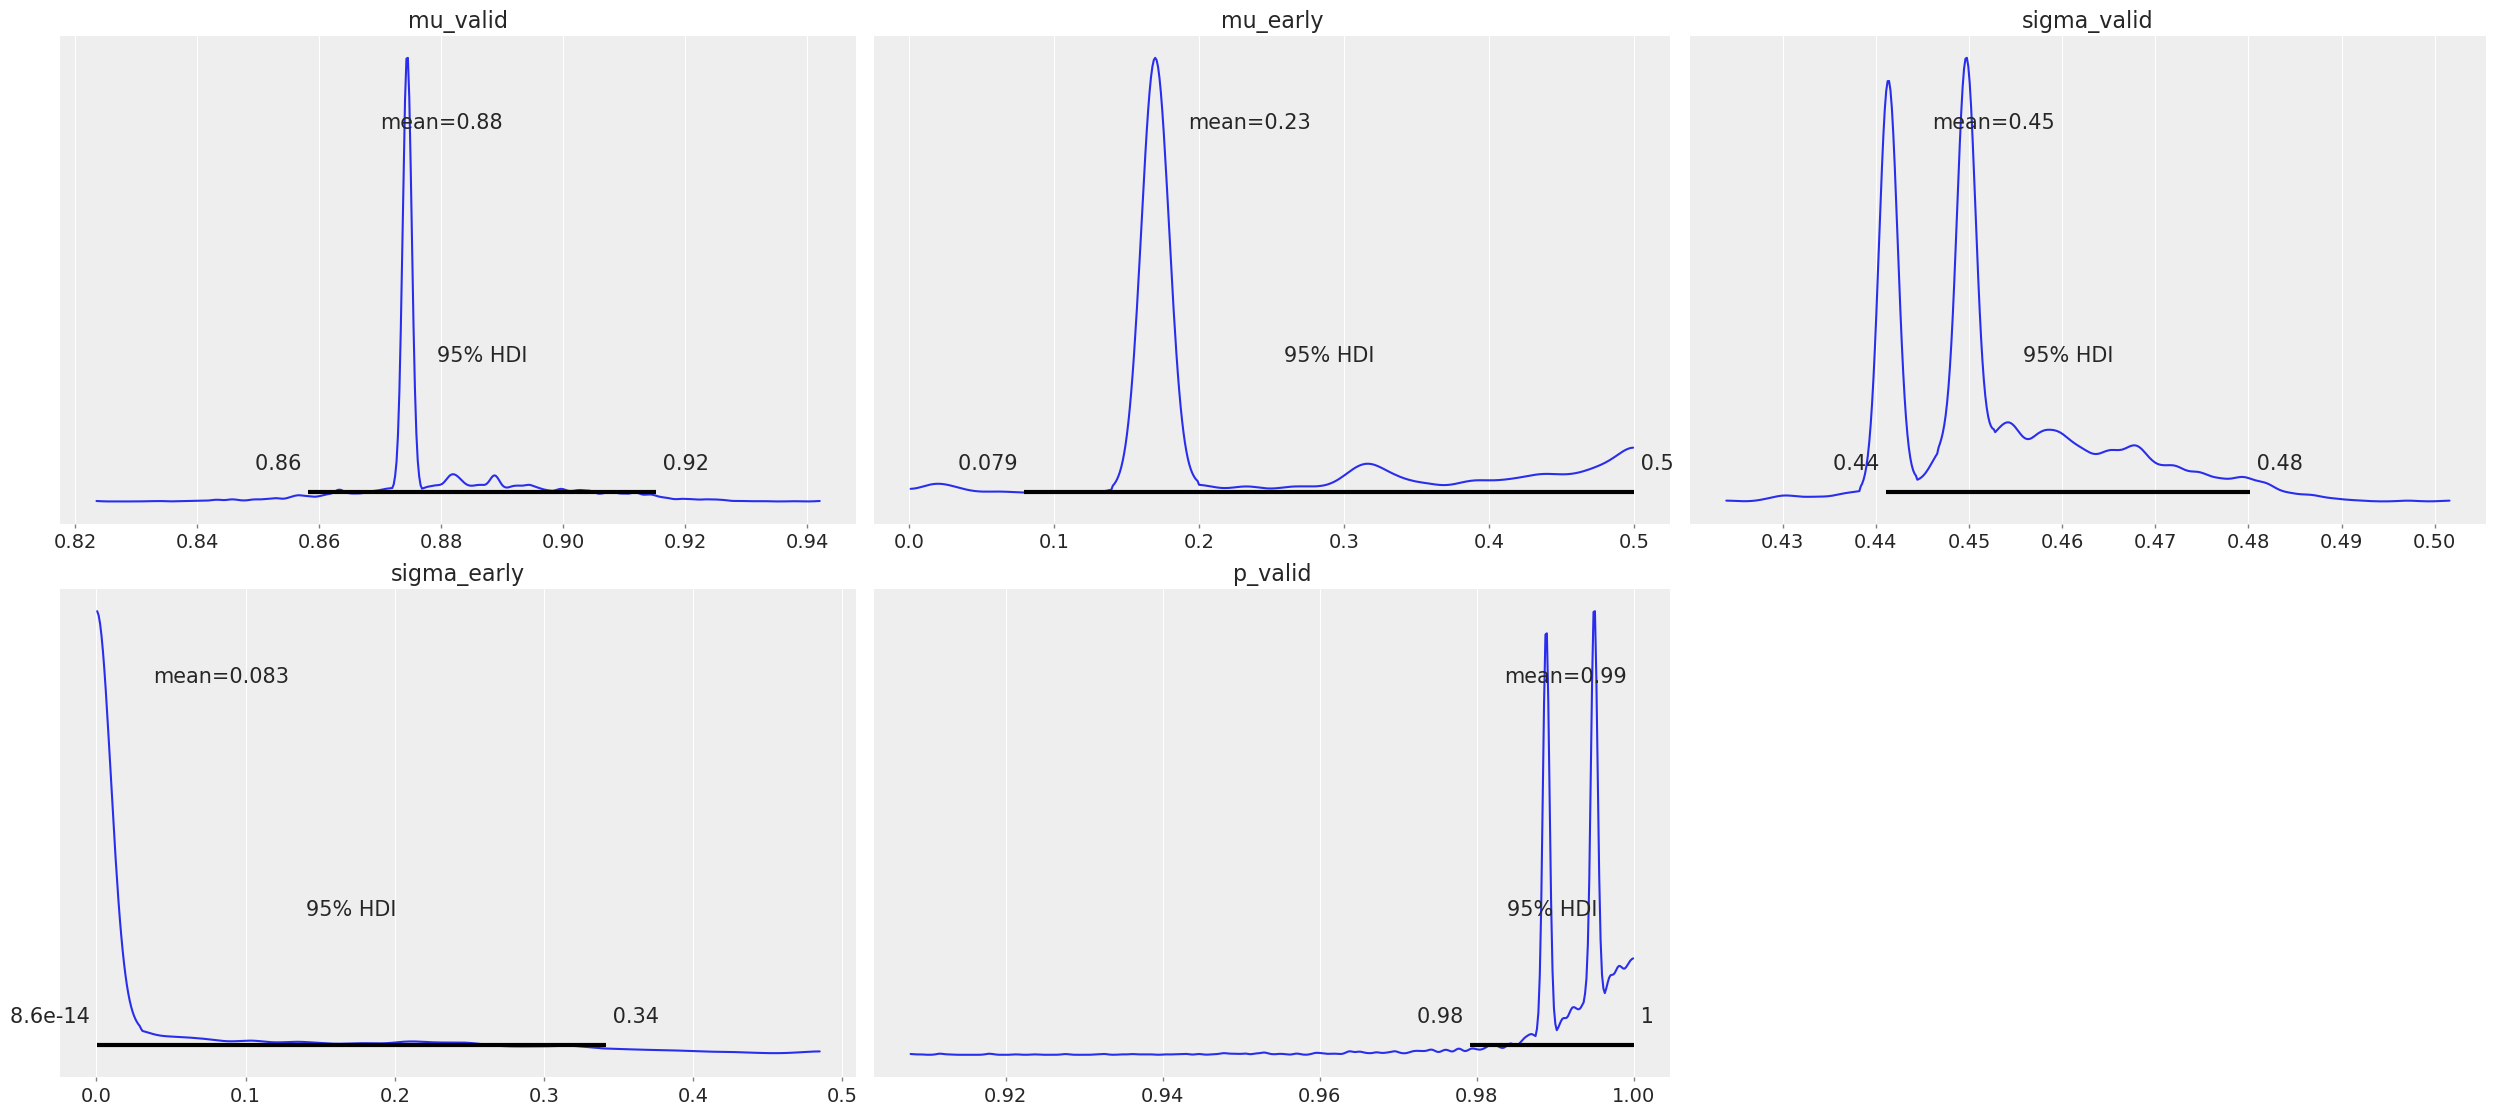

In [96]:
az.plot_posterior(trace_post, var_names=["mu_valid", "mu_early", "sigma_valid", "sigma_early", "p_valid"])


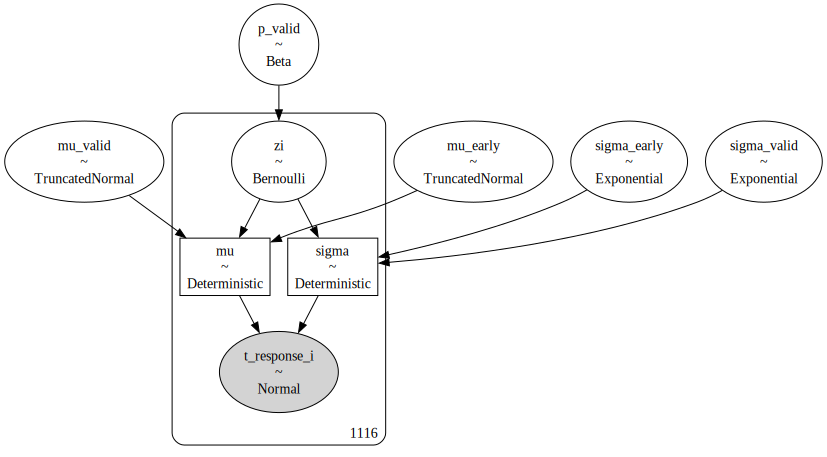

In [62]:
with pm.Model() as model_pre:

    # prior of mu, wide distributed around 1.
    mu_valid = pm.TruncatedNormal("mu_valid", mu=1., sigma=.5, lower=0.)
    mu_early = pm.TruncatedNormal("mu_early", mu=0., sigma=.5, lower=0., upper=.5)

    # prior of sigma, larger than 0., and close to 0.
    sigma_valid = pm.Exponential("sigma_valid", lam=5.)
    sigma_early = pm.Exponential("sigma_early", lam=5.)

    # treatment, get from data
    p_valid = pm.Beta("p_valid", alpha=5., beta=5.)
    zi = pm.Bernoulli("zi", p=p_valid, shape=n_pre)

    # assign parameters to each trial, according to treatment
    mu = pm.Deterministic("mu", pt.switch(pt.eq(zi, 1), mu_valid, mu_early))
    sigma = pm.Deterministic("sigma", pt.switch(pt.eq(zi, 1), sigma_valid, sigma_early))

    # observed data
    t_response_i = pm.Normal("t_response_i", mu=mu, sigma=sigma, observed=t_response_pre)

pm.model_to_graphviz(model_pre)

In [63]:
with model_pre:
    trace_pre = pm.sample(chains=4, draws=1000, tune=1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu_valid, mu_early, sigma_valid, sigma_early, p_valid]
>BinaryGibbsMetropolis: [zi]


KeyboardInterrupt: 

In [ ]:
az.summary(trace_pre, var_names=["mu_valid", "mu_early", "sigma_valid", "sigma_early", "p_valid"])


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_valid,1.128,0.020,1.089,1.165,0.000,0.000,3994.0,2879.0,1.0
mu_early,0.379,0.267,0.002,0.899,0.004,0.003,4064.0,2187.0,1.0
sigma_valid,0.648,0.014,0.622,0.674,0.000,0.000,3457.0,2986.0,1.0
sigma_early,0.197,0.195,0.000,0.590,0.003,0.002,2482.0,1748.0,1.0
p_valid,0.546,0.144,0.267,0.820,0.002,0.002,4049.0,2923.0,1.0
